In [1]:
# ----------------------------------------
# filename model_interpretability.ipynb
# author Partha Deka
# revision 1.1
# revision history 1.0 - initial script
# 1.1 - using California Housing dataset from scikit-learn

## Using XGBoost's Feature Importance with the California Housing Dataset

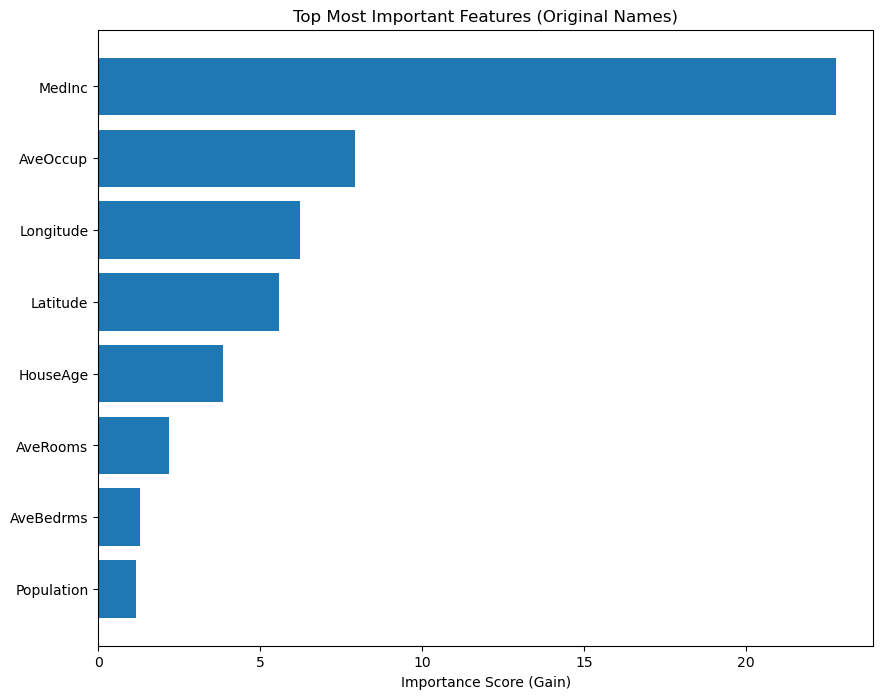

In [2]:
import xgboost as xgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt

# Load the California Housing dataset
housingX, housingy = datasets.fetch_california_housing (return_X_y=True, as_frame=True)

# Handle categorical variables by converting them to numeric using pd.get_dummies
housing_data_encoded = pd.get_dummies(housingX)

# Extract original feature names
original_feature_names = housing_data_encoded.columns

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(housing_data_encoded, housingy, test_size=0.2, random_state=42)

# Standardize the data for optimal performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train an XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror')
model.fit(X_train_scaled, y_train)

# Retrieve feature importance scores and map them back to original feature names
importance_dict = model.get_booster().get_score(importance_type='gain')

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': [original_feature_names[int(key[1:])] for key in importance_dict.keys()],
    'Importance': importance_dict.values()
})

# Sort the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the top most important features with original names
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'].head(20), importance_df['Importance'].head(20))
plt.title("Top Most Important Features (Original Names)")
plt.xlabel("Importance Score (Gain)")
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.show()


## Using SHAP with the Housing Dataset

c:\Users\joyce\anaconda3\envs\xgboost_book_eli5\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 95%|=================== | 3942/4128 [00:17<00:00]       

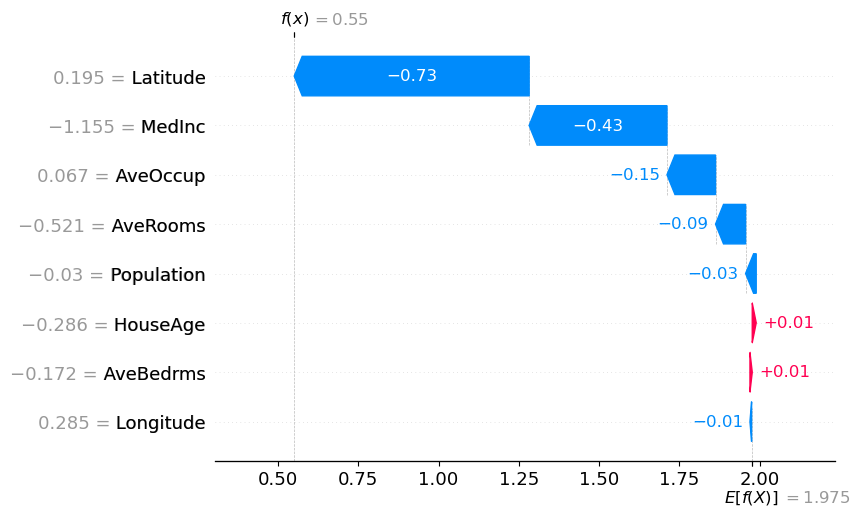

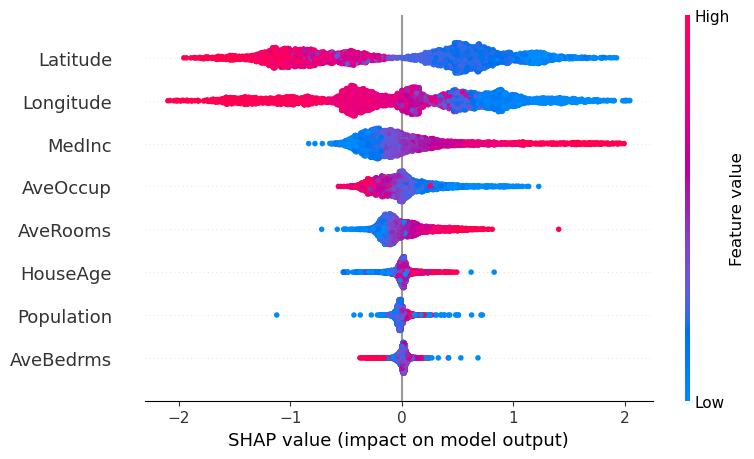

In [3]:
import shap
import pandas as pd

# Create a DataFrame for the scaled X_test with proper feature names
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Initialize SHAP explainer using the model and the scaled training data
explainer = shap.Explainer(model, X_train_scaled, feature_names=X_train.columns)

# Compute SHAP values for the test set
shap_values = explainer(X_test_scaled)

# SHAP Waterfall plot for a single prediction (now no need for feature_names parameter)
shap.waterfall_plot(shap_values[0])

# SHAP Summary plot for global feature importance (uses the DataFrame to preserve feature names)
shap.summary_plot(shap_values, X_test_scaled_df)


## Using LIME to Interpret XGBoost Predictions

In [4]:
import lime
import lime.lime_tabular
import numpy as np
import pandas as pd

# Define a wrapper for model.predict to ensure it uses scaled data
def predict_fn(x):
    x_scaled = scaler.transform(x)  # Scale the data before predicting
    return model.predict(x_scaled).flatten()  # Ensure the output is 1D for LIME

# Initialize LIME explainer using the unscaled training data
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,  # Use unscaled data
    feature_names=X_train.columns, 
    mode='regression',
    discretize_continuous=False  # Disable discretization for continuous features
)

# Explain a single instance (e.g., the first test instance)
i = 0
exp = explainer.explain_instance(X_test.values[i], predict_fn, num_features=5)

# Show the explanation
exp.show_in_notebook(show_table=True)


## Using ELI5 to Explain XGBoost Models

In [5]:
import eli5
from eli5.sklearn import PermutationImportance

# Fit the permutation importance model
perm = PermutationImportance(model, random_state=42).fit(X_test_scaled, y_test)

# Display feature importance using ELI5
eli5.show_weights(perm, feature_names=X_test.columns.tolist())


Weight,Feature
1.4844 ± 0.0597,Latitude
1.2758 ± 0.0660,Longitude
0.4154 ± 0.0172,MedInc
0.1452 ± 0.0115,AveOccup
0.0792 ± 0.0057,AveRooms
0.0469 ± 0.0088,HouseAge
0.0068 ± 0.0035,AveBedrms
0.0031 ± 0.0042,Population


## `PDP` implementatipon on the Housing dataset using scikit-learn's `PartialDependenceDisplay`

In [6]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.inspection import plot_partial_dependence
import matplotlib.pyplot as plt
import pandas as pd

# Load the housing dataset
housingX, housingy = datasets.fetch_california_housing (return_X_y=True, as_frame=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(housingX, housingy, test_size=0.2, random_state=42)

# Train the Gradient Boosting model
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
gbr.fit(X_train, y_train)

# Get feature importances from the Gradient Boosting model
importances = gbr.feature_importances_

# Create a DataFrame to pair feature names with their importance scores
feature_importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Sort the features by importance and select the top 6
top_features = feature_importances_df.sort_values(by='Importance', ascending=False).head(6)
print("Top 6 Important Features:")
print(top_features)

Top 6 Important Features:
     Feature  Importance
0     MedInc    0.578121
5   AveOccup    0.132026
7  Longitude    0.105324
6   Latitude    0.096638
1   HouseAge    0.043179
2   AveRooms    0.025655


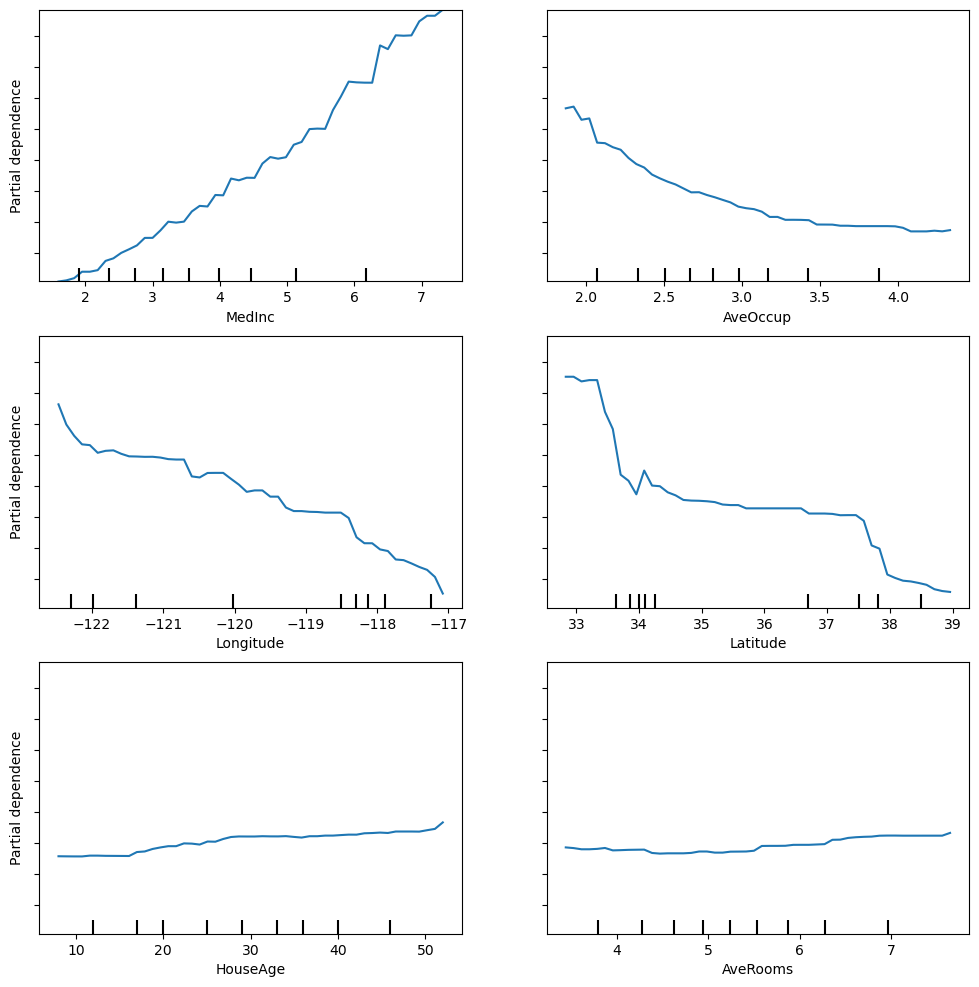

In [9]:
# Get the indices of the top 6 features
top_features_indices = [X_train.columns.get_loc(feature) for feature in top_features['Feature']]

# Generate PDP plots for the top 6 features
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 12), sharey = True)
plot_partial_dependence(gbr, X_train, top_features_indices, feature_names=X_train.columns, grid_resolution=50, ax=ax)

# Show the plots
plt.show()